# Rede com contração e expansão - MNIST

## Importando módulos

In [1]:
import os
import pkgutil

if pkgutil.find_loader('torch') is None:
    from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
    platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

    accelerator = 'cu80' if os.path.exists('/opt/bin/nvidia-smi') else 'cpu'

    !pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision

In [2]:
%matplotlib inline

import time
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

import torch
import torchvision
from torchvision.datasets import MNIST

In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print("Device:", device)

Device: cuda


## Dataset

In [4]:
dataset_dir = '../data/MNIST/processed/'

In [5]:
class CustomMNIST(torch.utils.data.Dataset):
    def __init__(self, processed_data_dir, length, mat_size=160, num_cells=10, debug=False):
        num_attempts = 15
        cell_size = mat_size/num_cells
        cell_central_pixel = np.arange(cell_size/2, mat_size, cell_size)
        cell_pixel_between = (cell_central_pixel[:-1] + cell_central_pixel[1:]) // 2

        test_data, test_label = torch.load(os.path.join(processed_data_dir, 'test.pt'))
        train_data, train_label = torch.load(os.path.join(processed_data_dir, 'training.pt'))

        joint_data = torch.cat((train_data, test_data), dim=0).type(torch.FloatTensor) / 255.0
        joint_label = torch.cat((train_label, test_label), dim=0)

        data_idx_array = np.arange(joint_data.shape[0])

        self.mat_image = torch.zeros((length, 1, mat_size, mat_size), dtype=torch.float)
        self.mat_label_reg = torch.zeros((length, 2, num_cells, num_cells), dtype=torch.float)
        self.mat_label_cls = torch.zeros((length, 2, num_cells, num_cells), dtype=torch.long)
        self.mat_label_cls[:, 0] = -1

        for sample_idx in range(length):
            np.random.shuffle(data_idx_array)
            num_digits = np.random.randint(7, 10)
            digit_idx_array = data_idx_array[:num_digits]

            frame_list = list()

            for digit_idx in digit_idx_array:
                digit_attempt = 0

                while digit_attempt != num_attempts:
                    x1, y1 = np.random.randint(0, mat_size-28, size=2)
                    x2, y2 = x1+28, y1+28

                    frame_idx = 0
                    while frame_idx != len(frame_list):
                        frame_entry = frame_list[frame_idx]

                        x1_between = (x1 >= frame_entry[0]) and (x1 < frame_entry[2])
                        x2_between = (x2 >= frame_entry[0]) and (x2 < frame_entry[2])
                        x_between = x1_between or x2_between

                        y1_between = (y1 >= frame_entry[1]) and (y1 < frame_entry[3])
                        y2_between = (y2 >= frame_entry[1]) and (y2 < frame_entry[3])
                        y_between = y1_between or y2_between

                        if x_between and y_between:
                            break
                        else:
                            frame_idx += 1

                    if frame_idx == len(frame_list):
                        frame_list.append([x1, y1, x2, y2])
                        break
                    else:
                        digit_attempt += 1

                if digit_attempt != num_attempts:
                    frame = frame_list[-1]
                    self.mat_image[sample_idx, 0, frame[1]:frame[3], frame[0]:frame[2]] = joint_data[digit_idx]

                    # Compute distance of digit centroid to each cell interface to pick the right cell and tx/ty
                    x_centroid = frame[0] + 14
                    y_centroid = frame[1] + 14

                    x_centroid_diff = cell_pixel_between - x_centroid
                    y_centroid_diff = cell_pixel_between - y_centroid

                    x_closest_pixel = np.argmin(np.abs(x_centroid_diff))
                    y_closest_pixel = np.argmin(np.abs(y_centroid_diff))

                    x_central_pixel_idx = x_closest_pixel if x_centroid_diff[x_closest_pixel] >= 0 else x_closest_pixel + 1
                    y_central_pixel_idx = y_closest_pixel if y_centroid_diff[y_closest_pixel] >= 0 else y_closest_pixel + 1

                    x_central_pixel = cell_central_pixel[x_central_pixel_idx]
                    y_central_pixel = cell_central_pixel[y_central_pixel_idx]

                    tx = cell_pixel_between[x_closest_pixel] - x_centroid_diff[x_closest_pixel] - x_central_pixel
                    ty = cell_pixel_between[y_closest_pixel] - y_centroid_diff[y_closest_pixel] - y_central_pixel

                    self.mat_label_reg[sample_idx, 0, y_central_pixel_idx, x_central_pixel_idx] = tx
                    self.mat_label_reg[sample_idx, 1, y_central_pixel_idx, x_central_pixel_idx] = ty
                    self.mat_label_cls[sample_idx, 0, y_central_pixel_idx, x_central_pixel_idx] = joint_label[digit_idx]
                    self.mat_label_cls[sample_idx, 1, y_central_pixel_idx, x_central_pixel_idx] = 1

                    if debug:
                        print(f'Digit {joint_label[digit_idx]}: coord {frame}')

        if not debug:
            self.mat_label_reg /= (cell_size / 2)

    def __len__(self):
        return len(self.mat_label_cls)

    def __getitem__(self, index):
        return self.mat_image[index], self.mat_label_reg[index], self.mat_label_cls[index]

### Visualização de exemplo

In [6]:
def vizSample(dataset, idx):
    image, label_reg, label_cls = dataset[idx]

    plt.imshow(image[0].numpy())
    plt.show()

    print(f'tx:\n{label_reg[0]}\n')
    print(f'ty:\n{label_reg[1]}\n')
    print(f'class:\n{label_cls[0]}\n')
    print(f'presence:\n{label_cls[1]}\n')

In [7]:
mnist_dataset = CustomMNIST(dataset_dir, 1, debug=True)

Digit 2: coord [91, 85, 119, 113]
Digit 4: coord [53, 118, 81, 146]
Digit 5: coord [15, 33, 43, 61]
Digit 1: coord [130, 68, 158, 96]
Digit 1: coord [53, 35, 81, 63]
Digit 3: coord [126, 16, 154, 44]
Digit 0: coord [9, 91, 37, 119]
Digit 8: coord [18, 0, 46, 28]


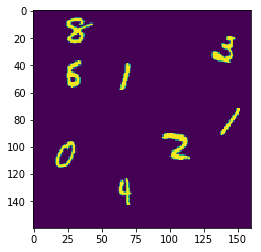

tx:
tensor([[ 0.,  8.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  4.,  0.],
        [ 0.,  5.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0., -5.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  8.,  0.],
        [ 0., -1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0., -5.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

ty:
tensor([[ 0.,  6.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  6.,  0.],
        [ 0.,  7.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0., -7.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -6.,  0.],
        [ 0.,  1.,  0.,  0.,  

In [8]:
vizSample(mnist_dataset, 0)

### Criação dos datasets de Treinamento, Validação e Teste

In [9]:
num_samples_train = 2000
num_samples_valid = 500
num_samples_test = 200

dataset_train = CustomMNIST(dataset_dir, num_samples_train)
dataset_valid = CustomMNIST(dataset_dir, num_samples_valid)
dataset_test = CustomMNIST(dataset_dir, num_samples_test)

## Dataloaders

In [10]:
batch_size = 64

dataloaders = {
    'train': torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=0),
    'valid': torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, shuffle=False, num_workers=0)
}

## Modelo de Rede Neural

In [11]:
class CustomModel(torch.nn.Module):
    def __init__(self):
        super(CustomModel, self).__init__()

        self.conv = torch.nn.Sequential(                                                 #   1 x 160 x 160
            torch.nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),   #  32 x 160 x 160
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(in_channels=32, out_channels=30, kernel_size=3, padding=1),  #  30 x 160 x 160
            torch.nn.LeakyReLU(),
            torch.nn.MaxPool2d(kernel_size=2),                                           #  30 x  80 x  80
            torch.nn.Conv2d(in_channels=30, out_channels=28, kernel_size=3, padding=1),  #  28 x  80 x  80
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(in_channels=28, out_channels=26, kernel_size=3, padding=1),  #  26 x  80 x  80
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(in_channels=26, out_channels=24, kernel_size=3, padding=1),  #  24 x  80 x  80
            torch.nn.LeakyReLU(),
            torch.nn.MaxPool2d(kernel_size=2),                                           #  24 x  40 x  40
            torch.nn.Conv2d(in_channels=24, out_channels=22, kernel_size=3, padding=1),  #  22 x  40 x  40
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(in_channels=22, out_channels=20, kernel_size=3, padding=1),  #  20 x  40 x  40
            torch.nn.LeakyReLU(),
            torch.nn.MaxPool2d(kernel_size=2),                                           #  20 x  20 x  20
            torch.nn.Conv2d(in_channels=20, out_channels=18, kernel_size=3, padding=1),  #  18 x  20 x  20
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(in_channels=18, out_channels=16, kernel_size=3, padding=1),  #  16 x  20 x  20
            torch.nn.LeakyReLU(),
            torch.nn.MaxPool2d(kernel_size=2),                                           #  16 x  10 x  10
            torch.nn.Conv2d(in_channels=16, out_channels=14, kernel_size=3, padding=1),  #  14 x  10 x  10
        )

    def forward(self, x):
        x = self.conv(x)

        return x

## Função de perda customizada

In [12]:
class CustomLoss(torch.nn.Module):
    def __init__(self):
        super().__init__()
        presence_weights = torch.tensor([0.1, 1]).to(device)
        self.cel_presence = torch.nn.CrossEntropyLoss(weight=presence_weights)
        self.cel_class = torch.nn.CrossEntropyLoss(ignore_index=-1)

    def customMSELoss(self, predict, target, mask):
        num_elem = torch.sum(mask, (3, 2, 1))
        mse_loss_calc_1 = (predict - target) ** 2
        mse_loss_calc_2 = torch.sum(mse_loss_calc_1 * mask, (3, 2, 1)) / num_elem
        return torch.sum(mse_loss_calc_2) / len(mse_loss_calc_2)

    def forward(self, predict, target_reg, target_cls):
        # predict: M, 14, 10, 10
        loss_presence = self.cel_presence(predict[:, 12:], target_cls[:, 1])
        loss_class = self.cel_class(predict[:, 2:12], target_cls[:, 0])
        loss_t = self.customMSELoss(predict[:, :2], target_reg, target_cls[:, 1:].type(torch.float))

        return loss_presence + loss_class + loss_t

## Teste das etapas (dataloader, modelo e função de perda)

In [13]:
label_entries = ['tx', 'ty', 'class', 'presence']

dataiter = iter(dataloaders['train'])
sample_images, sample_labels_reg, sample_labels_cls = dataiter.next()

print(f'Entrada')
print(f'    Formato: {sample_images.shape}')
print(f'    Tipo: {sample_images.dtype}')
print(f'    Faixa de valores: [{sample_images.min()}, {sample_images.max()}]')
print()
print(f'Label')
print(f'    tx')
print(f'        Formato: {sample_labels_reg.shape}')
print(f'        Tipo: {sample_labels_reg.dtype}')
print(f'        Faixa de valores: [{sample_labels_reg[:, 0].min()}, {sample_labels_reg[:, 0].max()}]')
print(f'    ty')
print(f'        Formato: {sample_labels_reg.shape}')
print(f'        Tipo: {sample_labels_reg.dtype}')
print(f'        Faixa de valores: [{sample_labels_reg[:, 1].min()}, {sample_labels_reg[:, 1].max()}]')
print(f'    class')
print(f'        Formato: {sample_labels_cls.shape}')
print(f'        Tipo: {sample_labels_cls.dtype}')
print(f'        Faixa de valores: [{sample_labels_cls[:, 0].min()}, {sample_labels_cls[:, 0].max()}]')
print(f'    presence')
print(f'        Formato: {sample_labels_cls.shape}')
print(f'        Tipo: {sample_labels_cls.dtype}')
print(f'        Faixa de valores: [{sample_labels_cls[:, 1].min()}, {sample_labels_cls[:, 1].max()}]')

Entrada
    Formato: torch.Size([64, 1, 160, 160])
    Tipo: torch.float32
    Faixa de valores: [0.0, 1.0]

Label
    tx
        Formato: torch.Size([64, 2, 10, 10])
        Tipo: torch.float32
        Faixa de valores: [-0.875, 1.0]
    ty
        Formato: torch.Size([64, 2, 10, 10])
        Tipo: torch.float32
        Faixa de valores: [-0.875, 1.0]
    class
        Formato: torch.Size([64, 2, 10, 10])
        Tipo: torch.int64
        Faixa de valores: [-1, 9]
    presence
        Formato: torch.Size([64, 2, 10, 10])
        Tipo: torch.int64
        Faixa de valores: [0, 1]


In [14]:
custom_model = CustomModel().to(device)
sample_images = sample_images.to(device)
output = custom_model(sample_images)

print(f'Saida')
print(f'    Formato: {output.shape}')
print(f'    Tipo: {output.dtype}')
print(f'    Faixa de valores: [{output.min()}, {output.max()}]')

Saida
    Formato: torch.Size([64, 14, 10, 10])
    Tipo: torch.float32
    Faixa de valores: [-0.07266690582036972, 0.10481467843055725]


In [15]:
crit = CustomLoss()
sample_labels_reg = sample_labels_reg.to(device)
sample_labels_cls = sample_labels_cls.to(device)
loss = crit(output, sample_labels_reg, sample_labels_cls)
print(f'loss: {loss}')

loss: 3.700187921524048


## Treinamento

In [16]:
n_epochs = 100

optm = torch.optim.Adam(params=custom_model.parameters(), lr=1.e-4, betas=(0.9, 0.999))
schd = torch.optim.lr_scheduler.StepLR(optm, step_size=10, gamma=0.75)

In [17]:
def train_session(model, dataloaders, num_epochs, optimizer, criterion):
    num_train_samples = len(dataloaders['train'].dataset)
    num_valid_samples = len(dataloaders['valid'].dataset)
    train_batch_size = dataloaders['train'].batch_size
    valid_batch_size = dataloaders['valid'].batch_size

    num_train_batches = num_train_samples // train_batch_size
    num_valid_batches = num_valid_samples // valid_batch_size

    batch_print_size = 10

    epoch_train_loss_history = list()
    epoch_valid_loss_history = list()
    print('Start training for {} epochs'.format(num_epochs))

    try:
        for epoch in range(num_epochs):  # loop over the dataset multiple times
            train_t0 = time.time()
            epoch_train_loss = 0.0
            running_loss = 0.0

            for i, samples in enumerate(dataloaders['train']):
                # get the inputs
                images = samples[0].to(device)
                labels_reg = samples[1].to(device)
                labels_cls = samples[2].to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward + backward + optimize
                outputs = custom_model(images)
                loss = criterion(outputs, labels_reg, labels_cls)
                loss_value = loss.cpu().item()
                loss.backward()
                optimizer.step()

                # Update loss totals
                running_loss += loss_value
                epoch_train_loss += loss_value

                # print statistics
                if i % batch_print_size == (batch_print_size - 1):
                    print(f'Train batch {i+1}/{num_train_batches}: loss {running_loss/batch_print_size}', end='\r')
                    running_loss = 0.0

            epoch_train_loss /= num_train_samples
            train_t1 = time.time() - train_t0


            valid_t0 = time.time()
            epoch_valid_loss = 0.0
            running_loss = 0.0

            with torch.no_grad():
                for i, samples in enumerate(dataloaders['valid']):
                    # get the inputs
                    images = samples[0].to(device)
                    labels_reg = samples[1].to(device)
                    labels_cls = samples[2].to(device)

                    # forward
                    outputs = model(images)
                    loss = criterion(outputs, labels_reg, labels_cls)
                    loss_value = loss.cpu().item()

                    # Update loss totals
                    running_loss += loss_value
                    epoch_valid_loss += loss_value

                    # print statistics
                    if i % batch_print_size == (batch_print_size - 1):
                        print(f'Valid batch {i+1}/{num_valid_batches}: loss {running_loss/batch_print_size}', end='\r')
                        running_loss = 0.0

            epoch_valid_loss /= num_valid_samples
            valid_t1 = time.time() - valid_t0

            epoch_train_loss_history.append(epoch_train_loss)
            epoch_valid_loss_history.append(epoch_valid_loss)

            print(f'Epoch {epoch:3d} > train: T={train_t1:5.1f}s | loss={epoch_train_loss}  valid: T={valid_t1:5.1f}s | loss={epoch_valid_loss}')

        print('Finished Training')
    except KeyboardInterrupt:
        print('Finished by user')
        
    return epoch_train_loss_history, epoch_valid_loss_history

In [18]:
def save_loss_history(loss_history_list, loss_history_filename):
    file_obj = open(loss_history_filename, 'w')
    for entry in loss_history_list:
        file_obj.write(str(entry) + '\n')
    file_obj.close()

def load_loss_history(loss_history_filename):
    loss_history_list = list()

    file_obj = open(loss_history_filename, 'r')
    for line in file_obj:
        loss_history_list.append(float(line.strip()))
    file_obj.close()

    return loss_history_list

In [19]:
train = True
epoch_train_loss_history_filename = 'epoch_train_loss_history.txt'
epoch_valid_loss_history_filename = 'epoch_valid_loss_history.txt'

In [20]:
if train:
    epoch_train_loss_history, epoch_valid_loss_history = train_session(custom_model, dataloaders, n_epochs, optm, crit)
    torch.save(custom_model.state_dict(), './model/custom_model')
    save_loss_history(epoch_train_loss_history, epoch_train_loss_history_filename)
    save_loss_history(epoch_valid_loss_history, epoch_valid_loss_history_filename)
else:
    custom_model.load_state_dict(torch.load('./model/custom_model'))
    epoch_train_loss_history = load_loss_history(epoch_train_loss_history_filename)
    epoch_valid_loss_history = load_loss_history(epoch_valid_loss_history_filename)

Start training for 100 epochs
Epoch   0 > train: T= 10.8s | loss=0.05902784836292267  valid: T=  0.9s | loss=0.059178128242492675
Epoch   1 > train: T= 10.8s | loss=0.058719566702842715  valid: T=  0.9s | loss=0.05791089344024658
Epoch   2 > train: T= 10.8s | loss=0.05286483919620514  valid: T=  0.9s | loss=0.048406164646148685
Epoch   3 > train: T= 10.8s | loss=0.046346840023994446  valid: T=  0.9s | loss=0.04504358243942261
Epoch   4 > train: T= 10.8s | loss=0.04395858776569366  valid: T=  0.9s | loss=0.04329837036132812
Epoch   5 > train: T= 10.8s | loss=0.04251967084407807  valid: T=  0.9s | loss=0.042063541412353515
Epoch   6 > train: T= 10.8s | loss=0.0413796535730362  valid: T=  0.9s | loss=0.04108750581741333
Epoch   7 > train: T= 10.8s | loss=0.040407607197761534  valid: T=  0.9s | loss=0.04003939628601074
Epoch   8 > train: T= 10.8s | loss=0.039281105279922485  valid: T=  0.9s | loss=0.03892940330505371
Epoch   9 > train: T= 10.8s | loss=0.037996019124984744  valid: T=  0.9s 

### Evolução do treinamento

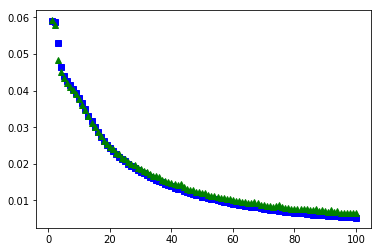

In [21]:
a_epochs = np.arange(1, 1 + len(epoch_train_loss_history))
plt.plot(a_epochs, epoch_train_loss_history, 'bs', a_epochs, epoch_valid_loss_history, 'g^')
plt.show()

### Cálculo da acurácia no conjunto de testes

In [49]:
test_loss = list()

test_image = list()

test_label_reg = list()
test_label_class = list()
test_label_presence = list()

test_output_reg = list()
test_output_class = list()
test_output_presence = list()

with torch.no_grad():
    for i, samples in enumerate(dataset_test):
        # get the inputs
        images = samples[0].unsqueeze(0).to(device)
        labels_reg = samples[1].unsqueeze(0).to(device)
        labels_cls = samples[2].unsqueeze(0).to(device)

        # forward
        outputs = custom_model(images)
        loss = crit(outputs, labels_reg, labels_cls)

        test_loss.append(loss.cpu().item())

        test_image.append(samples[0].numpy())

        test_label_reg.append(samples[1].numpy())
        test_output_reg.append(outputs[0, 0:2].cpu().numpy())

        samples_cls_array = samples[2].numpy()
        test_label_class.append(samples_cls_array[0])
        test_output_class.append(np.argmax(outputs[0, 2:12].cpu().numpy(), axis=0))

        test_label_presence.append(samples_cls_array[1])
        test_output_presence.append(np.argmax(outputs[0, 12:].cpu().numpy(), axis=0))

In [66]:
test_loss_array = np.array(test_loss)
test_loss_idx = np.argsort(test_loss_array)

test_arrays = {
    'image_array': np.concatenate(test_image),
    'label_reg_array': np.stack(test_label_reg),
    'output_reg_array': np.stack(test_output_reg),
    'label_class_array': np.stack(test_label_class),
    'output_class_array': np.stack(test_output_class),
    'label_presence_array': np.stack(test_label_presence),
    'output_presence_array': np.stack(test_output_presence)
}

In [63]:
test_label_reg_array.shape

(200, 2, 10, 10)

In [67]:
num_digits = np.sum(test_arrays['label_presence_array'])
predicted_digits = (test_arrays['output_class_array'] * test_arrays['output_presence_array'])
correct_digits = np.sum(predicted_digits == test_arrays['label_class_array'])
print(f'Acurácia: {num_correct_samples * 100.0 / num_digits}%')

Acurácia: 90.78282828282828%


In [72]:
def vizResult(idx, arrays_dict):
    plt.imshow(arrays_dict['image_array'][idx])
    plt.show()

    print(f'tx label:\n{np.around(arrays_dict["label_reg_array"][idx, 0], decimals=2)}\n')
    print(f'tx predict:\n{np.around(arrays_dict["output_reg_array"][idx, 0], decimals=2)}\n')
    print()
    print(f'ty label:\n{np.around(arrays_dict["label_reg_array"][idx, 1], decimals=2)}\n')
    print(f'ty predict:\n{np.around(arrays_dict["output_reg_array"][idx, 1], decimals=2)}\n')
    print()
    print(f'class label:\n{arrays_dict["label_class_array"][idx]}\n')
    print(f'class predict:\n{arrays_dict["output_class_array"][idx]}\n')
    print()
    print(f'presence label:\n{arrays_dict["label_presence_array"][idx]}\n')
    print(f'presence predict:\n{arrays_dict["output_presence_array"][idx]}\n')

In [ ]:
def vizResultImage(idx, arrays_dict):
    cell_central_pixel = np.arange(8, 160, 16)
    cell_central_pixel_mat = np.meshgrid(cell_central_pixel, cell_central_pixel)

    label_presence_idxs = arrays_dict['label_presence_array'][idx].nonzero()
    output_presence_idxs = arrays_dict['output_presence_array'][idx].nonzero()

    label_cell_central_pixel_x_array = cell_central_pixel_mat[0][label_presence_idxs]
    label_cell_central_pixel_y_array = cell_central_pixel_mat[1][label_presence_idxs]
    label_frame_array = label_cell_central_pixel_x_array - 14

    output_cell_central_pixel_x_array = cell_central_pixel_mat[0][output_presence_idxs]
    output_cell_central_pixel_y_array = cell_central_pixel_mat[1][output_presence_idxs]

    label_tx_array = arrays_dict['label_reg_array'][idx, 0][label_presence_idxs] * 8.0
    output_tx_array = arrays_dict['output_reg_array'][idx, 0][output_presence_idxs] * 8.0

    label_ty_array = arrays_dict['label_reg_array'][idx, 1][label_presence_idxs] * 8.0
    output_ty_array = arrays_dict['output_reg_array'][idx, 1][output_presence_idxs] * 8.0

    label_class_array = arrays_dict['label_class_array'][idx][label_presence_idxs]
    output_class_array = arrays_dict['output_class_array'][idx][output_presence_idxs]

    ax = plt.imshow(arrays_dict['image_array'][idx])
    for entry_idx in range(len(label_presence_idxs)):
        centroid = label_presence_idxs[entry_idx] + 8
        bbox = []
        ax.add_patch(patches.Rectangle(entry['bbox'][:2], entry['bbox'][2], entry['bbox'][3],
                                       fill=False, edgecolor='blue', lw=2))

        ax.set_title(f'{entry["label"]} - {entry["image"].shape}')
        ax.axis('off')
    plt.show()

    num_imgs = len(image_ids)
    num_rows = int(np.ceil(num_imgs/num_cols))

    viz_transforms = torchvision.transforms.Compose([
        ToNumpy(),
        Normalize(reverse=True)
    ])

    for idx in range(num_imgs):
        img_id = image_ids[idx]
        entry = viz_transforms(dataset[img_id])

        ax = fig.add_subplot(num_rows, num_cols, 1 + idx)
        ax.imshow(entry['image'])

        h, w = entry['image'].shape[:2]

        ax.add_patch(patches.Rectangle(entry['bbox'][:2], entry['bbox'][2], entry['bbox'][3],
                                       fill=False, edgecolor='blue', lw=2))

        ax.set_title(f'{entry["label"]} - {entry["image"].shape}')
        ax.axis('off')
    plt.show()

### Exemplo com menor perda

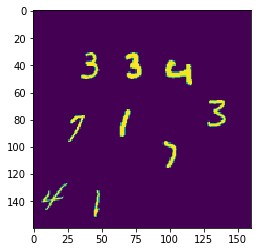

tx label:
[[ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.25  0.    0.25  0.    0.38  0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.   -0.12  0.  ]
 [ 0.    1.    0.    0.   -0.62  0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.   -0.38  0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.75  0.    0.75  0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]]

tx predict:
[[ 0.03  0.14  0.37  0.08  0.38  0.24  0.1   0.01  0.13  0.02]
 [-0.03  0.24  0.12  0.15  0.26  0.1   0.63  0.22  0.03 -0.28]
 [ 0.04  1.    0.3  -0.15  0.11 -0.19  0.53 -1.14 -0.11 -0.17]
 [ 0.12  0.7   0.29 -0.26  0.23 -0.46  0.39 -0.48  0.08 -0.3 ]
 [ 0.11  0.67  0.02  0.5  -0.26 -0.47  0.56  0.85 -0.19 -0.95]
 [ 0.57  0.87 -0.95  0.89 -0.69

In [73]:
vizResult(test_loss_idx[0], test_arrays)

### Exemplo com maior perda

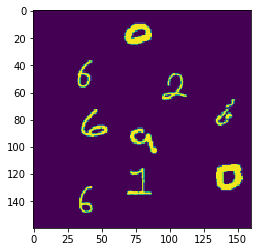

tx label:
[[ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.62  0.    0.    0.    0.    0.  ]
 [ 0.    0.   -0.38  0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.   -0.12  0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.5   0.  ]
 [ 0.    0.    0.5   0.    0.   -0.88  0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.62  0.    0.    0.    0.88  0.  ]
 [ 0.    0.   -0.25  0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]]

tx predict:
[[ 0.04  0.14  0.38  0.56  0.34 -0.31  0.04  0.09  0.22  0.04]
 [-0.02 -0.07  0.4   0.76  0.44 -0.93  0.3   0.09  0.12 -0.18]
 [-0.02  0.79 -0.35 -0.16  0.21  0.16  0.16 -0.17  0.08 -0.12]
 [-0.16  0.81 -0.25 -0.19  0.27  0.82 -0.01 -0.44  0.33 -0.57]
 [-0.02  0.33  0.48  0.03  0.28  0.49 -0.04  0.24  0.51 -0.99]
 [ 0.03  0.53  0.4  -0.65  0.67

In [75]:
vizResult(test_loss_idx[-1], test_arrays)

In [ ]:
matrix_image, matrix_label = matrixMNIST(dataset_test, model_output_size, num_h=num_h, num_w=num_w)
matrix_image = matrix_image.unsqueeze(0)
matrix_image_gauss_tensor = torch.cat((matrix_image, matrix_label), dim=0)
vizGaussNumber(matrix_image_gauss_tensor)

In [ ]:
matrix_image = matrix_image.unsqueeze(0).to(device)
matrix_label = matrix_label.unsqueeze(0).to(device)

with torch.no_grad():
    # forward
    matrix_outputs = model_ce(matrix_image)
    loss = crit(matrix_outputs, matrix_label)

    print(f'Valor da perda: {loss.cpu().item()}')

In [ ]:
matrix_image = matrix_image.cpu()[0]
matrix_outputs = matrix_outputs.cpu()[0]

In [ ]:
outputs_matrix_image_gauss_tensor = torch.cat((matrix_image, matrix_outputs), dim=0)
vizGaussNumber(outputs_matrix_image_gauss_tensor)

### Determinação de bounding boxes

In [ ]:
matrix_outputs_array = matrix_outputs.numpy()

In [ ]:
H = num_h * 28
W = num_w * 28
delta_dim = 28 // 2

matrix_outputs_bbox_label = np.empty((H, W), dtype='uint8')
matrix_outputs_bbox_sum = np.empty((H, W), dtype='float')

for row in range(H):
    row_start = np.maximum(0, row - delta_dim)
    row_end = np.minimum(H, row + delta_dim)

    for col in range(W):
        col_start = np.maximum(0, col - delta_dim)
        col_end = np.minimum(H, col + delta_dim)

        matrix_outputs_sum = np.sum(matrix_outputs_array[:, row_start:row_end, col_start:col_end], axis=(1, 2))
        matrix_outputs_bbox_label[row, col] = np.argmax(matrix_outputs_sum, axis=0)
        matrix_outputs_bbox_sum[row, col] = matrix_outputs_sum[matrix_outputs_bbox_label[row, col]]

bbox_threshold = 1
bbox_delta = np.array([[[delta_dim]],[[delta_dim]]])
matrix_outputs_bbox_idx = np.meshgrid(np.linspace(0,W-1,W), np.linspace(0,H-1,H))
matrix_outputs_bbox_start = np.maximum(0, matrix_outputs_bbox_idx - bbox_delta)
matrix_outputs_bbox_end = np.array([np.minimum(W, matrix_outputs_bbox_idx[0] + bbox_delta[0]),
                                    np.minimum(H, matrix_outputs_bbox_idx[1] + bbox_delta[1])])

for row in range(H):
    row_start = np.maximum(0, row - delta_dim)
    row_end = np.minimum(H, row + delta_dim)

    for col in range(W):
        col_start = np.maximum(0, col - delta_dim)
        col_end = np.minimum(H, col + delta_dim)


In [ ]:
print(matrix_outputs_bbox_sum[42])